In [60]:
from connect import get_token
import iot_api_client as iot
import datetime
from dateutil.tz import tzutc
import time as tm
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
token = get_token()

In [62]:
# Now we setup the iot-api Python client, first of all create a
# configuration object. The access token goes in the config object.
client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
# client_config.debug = True
client_config.access_token = token.get("access_token")

# Create the iot-api Python client with the given configuration
client = iot.ApiClient(client_config)

# Each API model has its own wrapper, here we want to interact with
# devices, so we create a DevicesV2Api object
client_devices = iot.DevicesV2Api(client)
client_things = iot.ThingsV2Api(client)
client_properties = iot.PropertiesV2Api(client)
client_series = iot.SeriesV2Api(client)

# Get a list of devices, catching the specific exception
try:
    devices = client_devices.devices_v2_list()
    things = client_things.things_v2_list()
    print('Response positive.')
except iot.ApiException as e:
    print("An exception occurred: {}".format(e))

for i in range(len(devices)):
    if devices[i].name=='Schantal':
        philipp_device_id = devices[i]

for i in range(len(things)):
    if things[i].name=='DS18B20_Logging_PHILIPP':
        philipp_thing = things[i]

#   Set IDs
device_id = philipp_device_id.id
thing_id = philipp_thing.id
properties = client_properties.properties_v2_list(thing_id)
temp0_id = properties[0].id

#client_devices.devices_v2_timeseries_with_http_info(thing_id, temp0_id, start='2022-11-08T14:00:00Z', limit=100)
to_date_dict = client_properties.properties_v2_timeseries(thing_id, temp0_id)

Response positive.


In [63]:
def get_temp_by_hour():
    token = get_token()
    client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
    client_config.access_token = token.get("access_token")
    client = iot.ApiClient(client_config)
    client_properties = iot.PropertiesV2Api(client)
    client_things = iot.ThingsV2Api(client)
    try:
        things = client_things.things_v2_list()
        print('Response positive.')
    except iot.ApiException as e:
        print("An exception occurred: {}".format(e))
    for i in range(len(things)):
        if things[i].name=='DS18B20_Logging_PHILIPP':
            philipp_thing = things[i]
    thing_id = philipp_thing.id
    properties = client_properties.properties_v2_list(thing_id)
    temp0_id = properties[0].id
    to_date_dict = client_properties.properties_v2_timeseries(thing_id, temp0_id)

    data_list = to_date_dict.data
    times, values = ([] for i in range(2))

    for el in data_list:
        times.append(el.time)
        values.append(el.value)

    df_data = pd.DataFrame({
        'datetime':times,
        'value': values
    })

    df_data['date'] = pd.to_datetime(df_data['datetime']).dt.date
    df_data['time'] = pd.to_datetime(df_data['datetime']).dt.time
    df_data['hour'] = pd.to_datetime(df_data['datetime']).dt.hour + pd.to_datetime(df_data['datetime']).dt.minute/60
    return df_data

Response positive.


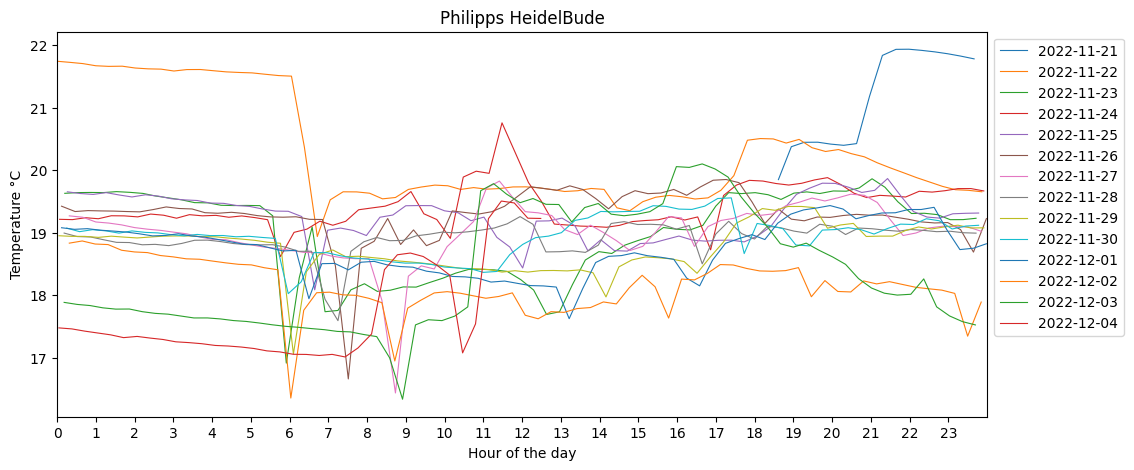

In [64]:
df_data = get_temp_by_hour()

fig, ax = plt.subplots(1, figsize=(12,5))

for date in df_data.date.unique():
    ax.plot(df_data[df_data.date==date]['hour'].values, df_data[df_data.date==date]['value'].values,label=date, lw=.8,)

ax.set_ylabel('Temperature °C')
ax.set_xlabel('Hour of the day')
ax.set_xlim(0, 24)
ax.set_xticks(range(24))
ax.set_title('Philipps HeidelBude')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left",  prop={'size': 10})

plt.show()

In [148]:
pd.to_datetime(df_data['datetime']).dt.strftime('%d-%m-%Y')

0      21-11-2022
1      21-11-2022
2      21-11-2022
3      21-11-2022
4      21-11-2022
          ...    
906    04-12-2022
907    04-12-2022
908    04-12-2022
909    04-12-2022
910    04-12-2022
Name: datetime, Length: 911, dtype: object

In [65]:
import plotly.express as px

fig = px.line(df_data, x='hour', y='value', color='date', template="simple_white")

fig.add_shape( # add a horizontal "target" line
    type="line",
    x0=0, x1=24, y0=20, yref="y"
)

fig.show()

In [71]:
def revive_connection():
    token = get_token()
    client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
    client_config.access_token = token.get("access_token")
    client = iot.ApiClient(client_config)
    client_properties = iot.PropertiesV2Api(client)
    client_things = iot.ThingsV2Api(client)
    return client_things, client_properties

def get_live_temp(client_things, client_properties):
    try:
        things = client_things.things_v2_list()
        for i in range(len(things)):
            if things[i].name=='DS18B20_Logging_PHILIPP':
                philipp_thing = things[i]
        thing_id = philipp_thing.id
        properties_list = client_properties.properties_v2_list(thing_id)
        temp0_id = properties_list[0].id
        properties_data = client_properties.properties_v2_show(thing_id, temp0_id)
        latest_data = properties_data.last_value
        latest_data_time = properties_data.last_value
        #print('Response positive.')
    except iot.ApiException as e:
        errorlogging = e 
        #print("An exception occurred: {}".format(e))
    return latest_data

In [72]:
import time

client_things, client_properties = revive_connection()

stop_button = False

while stop_button==False:
    start_time = time.time()
    time300 = time.time() - start_time
    client_things, client_properties = revive_connection()
    while time300<30:
        latest_data = get_live_temp(client_things, client_properties)
        print(latest_data)
        time.sleep(3)
        time300 = time.time() - start_time
    print('Token expired, getting a new one.')

19.25
19.3125
19.25
19.3125
19.3125
19.3125
19.3125
19.3125
19.3125
Token expired, getting a new one.
19.3125
19.25
19.25
19.9375
19.625
19.625
19.875
19.6875


KeyboardInterrupt: 

In [109]:
token = get_token()
client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
client_config.access_token = token.get("access_token")
client = iot.ApiClient(client_config)
client_properties = iot.PropertiesV2Api(client)
client_things = iot.ThingsV2Api(client)

things = client_things.things_v2_list()
for i in range(len(things)):
    if things[i].name=='DS18B20_Logging_PHILIPP':
        philipp_thing = things[i]
thing_id = philipp_thing.id
properties_list = client_properties.properties_v2_list(thing_id)
temp0_id = properties_list[0].id
properties_data = client_properties.properties_v2_show(thing_id, temp0_id)
latest_data = properties_data.last_value
latest_data_time = properties_data.last_value
#print('Response positive.')

In [118]:
from datetime import timedelta
(properties_data.value_updated_at+timedelta(hours=1)).time()

datetime.time(15, 7, 40, 446000)